In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil
from pypalettes import load_cmap
from pypalettes import get_hex

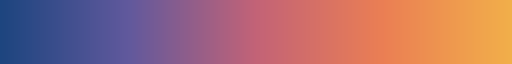

In [2]:
sunset2 = load_cmap('Sunset2', cmap_type='continuous')
sunset2

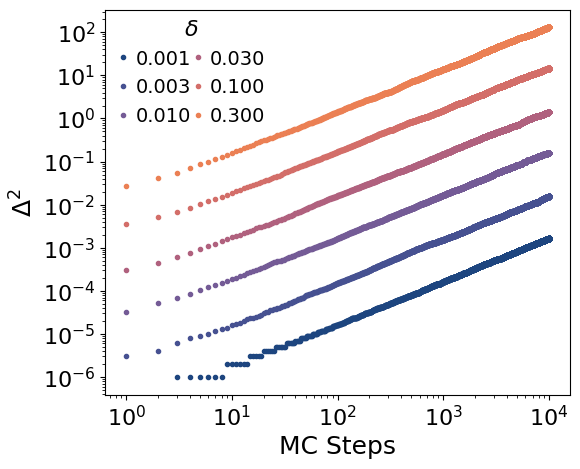

In [3]:
from scipy.optimize import curve_fit

# ---------- Config ----------
def linear_func(x, a, b):
    return a * x + b

delta = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
phi = 0.05
filenames = [f"results/1_MSD_phi{phi:.3f}_delta{d:.3f}.txt" for d in delta]

k = 0
D = []
errD = []
plt.figure(figsize=(6,5))
for file in filenames:
    data = np.loadtxt(file)
    MCsteps = data[:, 0]
    MSD = data[:, 1]
    popcvt, pcov = curve_fit(linear_func, MCsteps, MSD)
    D.append(popcvt[0]/4)
    errD.append(np.sqrt(np.diag(pcov))[0]/4)
    plt.plot(MCsteps, MSD, color = sunset2(k*0.15), lw = 0, markersize = 3, marker = 'o', label = f'{delta[k]:.3f}')
    k += 1

plt.xscale('log')
plt.yscale('log')
plt.xlabel('MC Steps', fontsize=18)
plt.ylabel(r'$\Delta^2$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(
    ncol=2,                      # reparte en 2 columnas
    title=r'$\delta$',
    fontsize=14, title_fontsize=16,
    loc='upper left',
    bbox_to_anchor=(-0.01, 1.02), # un poco de margen
    framealpha=0.0, facecolor='white',
    handlelength=0.5, handletextpad=0.4, columnspacing=0.1
)
# plt.xlim(1, 1e5)
plt.savefig('graphs/1_MSD_vs_MCsteps.pdf', dpi=300, bbox_inches='tight')
plt.show()

Slope: 1.9723570559457437
Intercept: -3.346405843253811


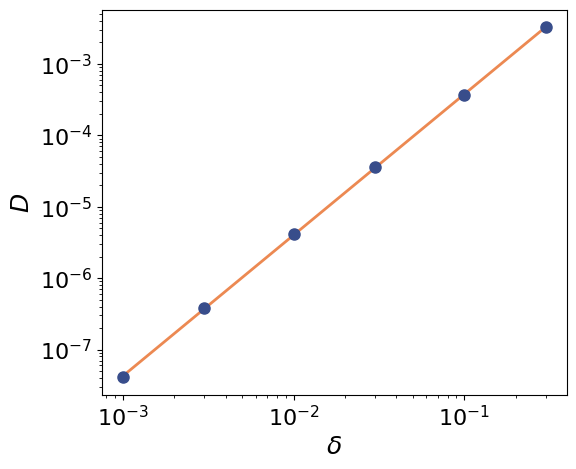

In [4]:
popcvt, pcov = curve_fit(linear_func, np.log(delta), np.log(D))
slope = popcvt[0]
n = popcvt[1]
print(f"Slope: {slope}")
print(f"Intercept: {n}")
x = np.linspace(min(delta), max(delta), 100)
y = np.exp(n) * x**slope
plt.figure(figsize=(6,5))
plt.plot(x, y, color=sunset2(0.8), lw=2)
plt.errorbar(delta, D, yerr=errD, fmt='o', color=sunset2(0.1), markersize=8)
plt.xlabel(r'$\delta$', fontsize=18)
plt.ylabel(r'$D$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xscale('log')
plt.yscale('log')
# plt.text(0.1, 0.9, r'$\sim \delta^{0.5}$', transform=plt.gca().transAxes, fontsize=16)
plt.savefig('graphs/1_D_vs_delta.pdf', dpi=300, bbox_inches='tight')
plt.show()


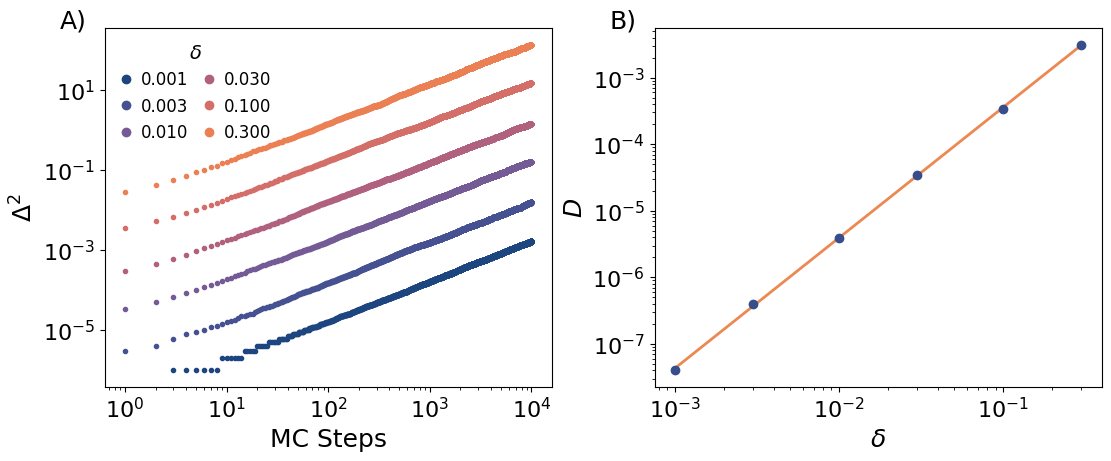

Exponente m: 1.959035
Prefactor A = exp(c): 0.0325319


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# =========================================================
# Config
# =========================================================
def linear_func(x, a, b):
    return a * x + b

# Ventana de ajuste en la "cola"
LAST_SPAN = 5000       # en unidades de pasos MC (no nº de puntos)
HIGHLIGHT_SEGMENT = True  # resaltar o no los puntos usados para el fit

# Si no tienes "sunset2", usa por ejemplo plt.cm.magma como colormap
# def sunset2(x): return plt.cm.magma(x)

delta = np.array([0.001, 0.003, 0.01, 0.03, 0.1, 0.3])
phi = 0.05
filenames = [f"results/1_MSD_phi{phi:.3f}_delta{d:.3f}.txt" for d in delta]

# =========================================================
# Helper: ajusta D en la cola de la serie
# =========================================================
def fit_D_last_span(MCsteps, MSD, span=LAST_SPAN):
    """Ajusta MSD = a t + b en la ventana [t_max - span, t_max].
       Devuelve D=a/4, errD, (a,b,cov), y la máscara usada."""
    t_max = MCsteps.max()
    t_min = max(MCsteps.min(), t_max - span)
    mask = MCsteps >= t_min

    # por si quedan muy pocos puntos (muestreo irregular):
    if mask.sum() < 5:
        mask = np.zeros_like(MCsteps, dtype=bool)
        mask[-max(5, len(MCsteps)//10):] = True

    pop, pcov = curve_fit(linear_func, MCsteps[mask], MSD[mask])
    a, b = pop
    D = a / 4.0
    errD = np.sqrt(np.diag(pcov))[0] / 4.0
    return D, errD, (a, b, pcov), mask

# =========================================================
# Cálculo y figura con subplots
# =========================================================
D, errD = [], []

fig, axs = plt.subplots(1, 2, figsize=(11, 4.5), constrained_layout=True)

# ----- (A) MSD vs MC steps -----
for k, file in enumerate(filenames):
    data = np.loadtxt(file)
    MCsteps = data[:, 0]
    MSD = data[:, 1]

    Di, eDi, (a, b, cov), mask = fit_D_last_span(MCsteps, MSD, span=LAST_SPAN)
    D.append(Di); errD.append(eDi)

    # Toda la curva
    axs[0].plot(MCsteps, MSD, color=sunset2(k*0.15),
                lw=0, marker='o', markersize=3, label=f'{delta[k]:.3f}')
    # Opcional: resaltar parte usada para el ajuste
    if HIGHLIGHT_SEGMENT:
        axs[0].plot(MCsteps[mask], MSD[mask], lw=2, color=sunset2(k*0.15), alpha=0.9)

axs[0].set_xscale('log'); axs[0].set_yscale('log')
axs[0].set_xlabel('MC Steps', fontsize=18)
axs[0].set_ylabel(r'$\Delta^2$', fontsize=18)
axs[0].tick_params(labelsize=16)
axs[0].legend(ncol=2, title=r'$\delta$', fontsize=12, title_fontsize=14,
              loc='upper left', framealpha=0.0, handlelength=0.8,
              handletextpad=0.5, columnspacing=0.8, markerscale=2.0, numpoints=1)
axs[0].text(-0.1, 1, f'A)', fontsize=18, transform=axs[0].transAxes)

# ----- (B) D vs delta + ajuste log-log -----
D = np.array(D); errD = np.array(errD)

# ajuste: log D = m log δ + c
popt, pcov = curve_fit(lambda x, m, c: m*x + c,
                       np.log(delta), np.log(D))
m, c = popt
delta_fit = np.linspace(delta.min(), delta.max(), 300)
D_fit = np.exp(c) * delta_fit**m

axs[1].errorbar(delta, D, yerr=errD, fmt='o', markersize=6,
                color=sunset2(0.1), capsize=3, label='datos')
axs[1].plot(delta_fit, D_fit, lw=2, color=sunset2(0.8),
            label=fr'fit: $D \propto \delta^{m}$')

axs[1].set_xscale('log'); axs[1].set_yscale('log')
axs[1].set_xlabel(r'$\delta$', fontsize=18)
axs[1].set_ylabel(r'$D$', fontsize=18)
axs[1].tick_params(labelsize=16)
axs[1].text(-0.1, 1, f'B)', fontsize=18, transform=axs[1].transAxes)

# axs[1].legend(fontsize=14, frameon=False)
# axs[1].text(0.05, 0.05, fr'$m={m:.3f}$',
#             transform=axs[1].transAxes, fontsize=13)

# Guardar y mostrar
plt.savefig('graphs/1_MSD_and_D_vs_delta_last5k.pdf', dpi=300)
plt.show()

print(f"Exponente m: {m:.6f}")
print(f"Prefactor A = exp(c): {np.exp(c):.6g}")


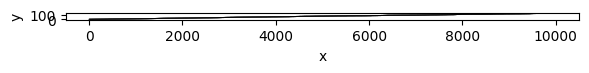

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection


phi = 0.05
initial_config = np.loadtxt("2_initial_positions_triang_phi0.5.txt")
positions = np.loadtxt(f"results/2_positions_triang_phi{phi:.3f}_delta0.100.txt")
x = data[:, 0]
y = data[:, 1]

# x, y ya cargados como arrays 1D en unidades "reales"
R = 0.5  # radio real

fig, ax = plt.subplots(figsize=(6,6))

# Crear patches (círculos) en coordenadas de datos
patches = [Circle((xi, yi), R) for xi, yi in zip(x, y)]
pc = PatchCollection(patches, facecolor=sunset2(0.9), edgecolor='black', linewidth=0.7, alpha=1)

ax.add_collection(pc)
ax.set_aspect('equal', adjustable='box')   # círculos = círculos (no elipses)
ax.autoscale_view()                        # encajar a los datos (o fija tus límites)
# ax.set_xlim(-L/2, L/2); ax.set_ylim(-L/2, L/2)  # si prefieres límites exactos

ax.set_xlabel('x'); ax.set_ylabel('y')
plt.tight_layout()
plt.show()


N = 1000 partículas, T = 100 frames de tiempo
Frames seleccionados: 0 (t=0.0), 50 (t=5000.0), 99 (t=9900.0)


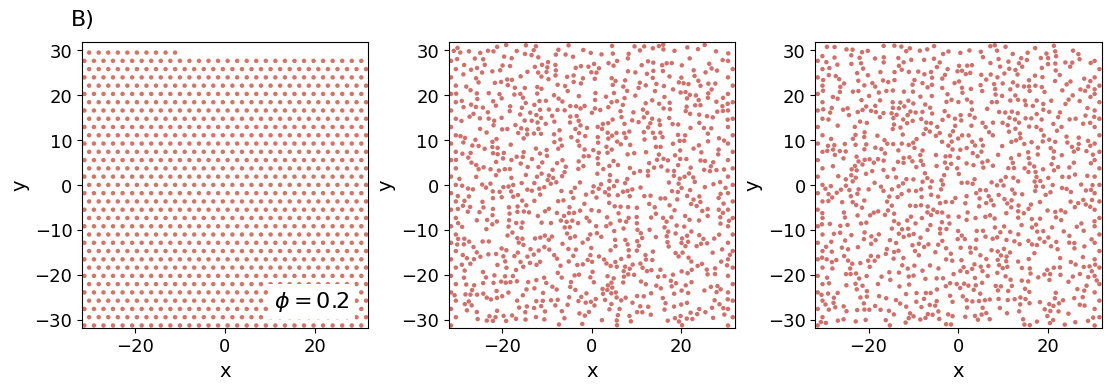

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

# ---------------- Config ----------------
phi = 0.2
R = 0.5  # radio real de cada partícula

# OJO: comprueba que el nombre de este fichero es correcto (en tu ejemplo es "phi0.5")
initial_path  = "2_initial_positions_triang_phi0.2.txt"
positions_path = f"results/2_positions_triang_phi{phi:.3f}_delta0.100.txt"

# ---------------- Lectura de datos ----------------
# Inicial: dos columnas (x, y) para N partículas
init_xy = np.loadtxt(initial_path)               # shape = (N, 2)
x0, y0 = init_xy[:, 0], init_xy[:, 1]
N = init_xy.shape[0]

# Evolución: filas = tiempos, col0 = t, luego (x1,y1,x2,y2,...,xN,yN)
pos = np.loadtxt(positions_path)                 # shape = (T, 1 + 2N)
t = pos[:, 0]
T = pos.shape[0]
print(f"N = {N} partículas, T = {T} frames de tiempo")

# índices de los tres “frames”
idx0 = 0
idx_mid = T // 2
idx_last = T - 1
print(f"Frames seleccionados: {idx0} (t={t[idx0]}), {idx_mid} (t={t[idx_mid]}), {idx_last} (t={t[idx_last]})")

def frame_xy(index):
    # columnas 1::2 son x, 2::2 son y
    xs = pos[index, 1::2]
    ys = pos[index, 2::2]
    return xs, ys

x_mid, y_mid   = frame_xy(idx_mid)
x_last, y_last = frame_xy(idx_last)

# ---------------- Helper de dibujo ----------------
def add_disks(ax, x, y, R, facecolor=None, edgecolor='black', lw=0.0, alpha=1.0):
    patches = [Circle((xi, yi), R) for xi, yi in zip(x, y)]
    pc = PatchCollection(patches, facecolor=facecolor, edgecolor=edgecolor,
                         linewidth=lw, alpha=alpha)
    ax.add_collection(pc)

# Limites comunes para que los tres paneles sean comparables
xmin = min(x0.min(), x_mid.min(), x_last.min()) - R
xmax = max(x0.max(), x_mid.max(), x_last.max()) + R
ymin = min(y0.min(), y_mid.min(), y_last.min()) - R
ymax = max(y0.max(), y_mid.max(), y_last.max()) + R

# ---------------- Figura 1×3 ----------------
fis, axs = plt.subplots(1, 3, figsize=(11, 4.5), constrained_layout=True)

# Panel 1: inicial
add_disks(axs[0], x0, y0, R, facecolor=sunset2(0.63))
# axs[0].set_title("t = 0", fontsize = 16)
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlim(xmin, xmax); axs[0].set_ylim(ymin, ymax)
axs[0].set_xlabel('x', fontsize=14); axs[0].set_ylabel('y', fontsize=14)
axs[0].tick_params(axis='both', which='both', labelsize = 13)
axs[0].text(-0.04, 1.06, f'B)', fontsize=16, transform=axs[0].transAxes)
axs[0].text(0.67,0.07, r'$\phi = 0.2$', fontsize=16, transform=axs[0].transAxes, bbox=dict(facecolor='white', edgecolor='none', alpha=1))



# Panel 2: tiempo medio
add_disks(axs[1], x_mid, y_mid, R, facecolor=sunset2(0.6))
# axs[1].set_title(f"t = 5000", fontsize = 16)
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlim(xmin, xmax); axs[1].set_ylim(ymin, ymax)
axs[1].set_xlabel('x', fontsize=14); axs[1].set_ylabel('y', fontsize=14)
axs[1].tick_params(axis='both', which='both', labelsize = 13)


# Panel 3: tiempo final
add_disks(axs[2], x_last, y_last, R, facecolor=sunset2(0.6))
# axs[2].set_title(f"t = 10000", fontsize=16)
axs[2].set_aspect('equal', adjustable='box')
axs[2].set_xlim(xmin, xmax); axs[2].set_ylim(ymin, ymax)
axs[2].set_xlabel('x', fontsize=14); axs[2].set_ylabel('y', fontsize=14)
axs[2].tick_params(axis='both', which='both', labelsize = 13)



plt.savefig('graphs/2_positions_triang_phi0.2_delta0.1.pdf', dpi=300, bbox_inches='tight')
plt.show()


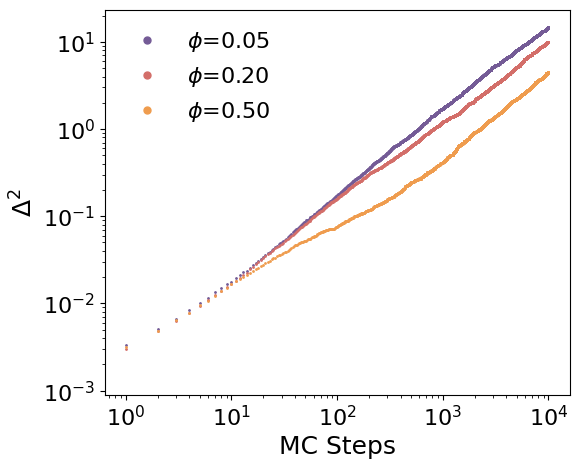

In [8]:
phi = [0.05, 0.2, 0.5]

filenames = [f"results/positions_triangular_phi{p:.3f}_delta0.100.txt" for p in phi]
filenamesMSD = [f"results/2_MSD_triang_phi{p:.3f}_delta0.100.txt" for p in phi]

plt.figure(figsize=(6,5))
i = 0
for file in filenamesMSD:
    data = np.loadtxt(file)
    MCsteps = data[:, 0]
    MSD = data[:, 1]
    plt.plot(MCsteps, MSD, marker='o', lw=0, markersize=1, label=r'$\phi$' + f'={phi[i]:.2f}', color = sunset2((i+1)*0.3))
    i += 1

plt.xscale('log')
plt.yscale('log')
plt.xlabel('MC Steps', fontsize=18)
plt.ylabel(r'$\Delta^2$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, markerscale=5, frameon=False)
plt.savefig('graphs/2_MSD_vs_MCsteps.pdf', dpi=300, bbox_inches='tight')
plt.show()


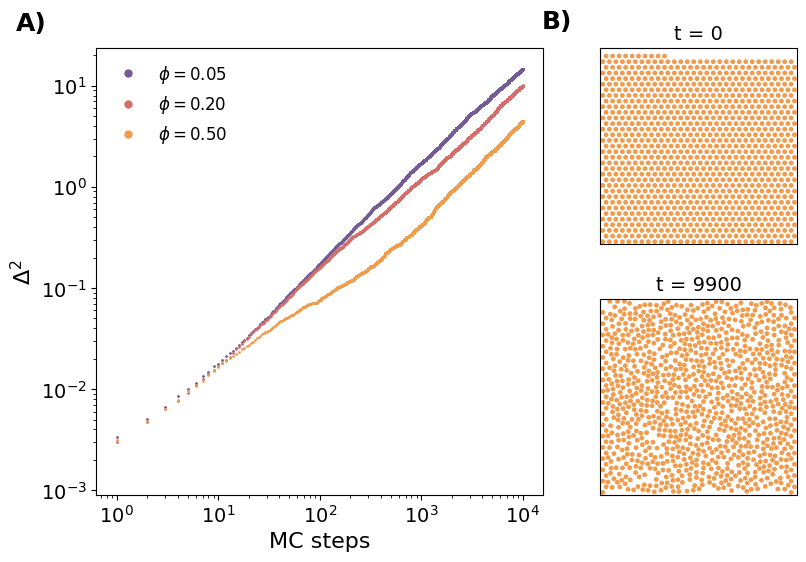

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

# =================== CONFIG ===================
# --- Configuraciones (panel B)
phi_conf = 0.5
R = 0.5  # radio de cada partícula
initial_path  = "2_initial_positions_triang_phi0.5.txt"
positions_path = f"results/2_positions_triang_phi{phi_conf:.3f}_delta0.100.txt"

# --- MSD (panel A)
phi_list = [0.05, 0.20, 0.50]
files_MSD = [f"results/2_MSD_triang_phi{p:.3f}_delta0.100.txt" for p in phi_list]

# =================== LECTURA DE DATOS ===================
# --- Configuraciones
init_xy = np.loadtxt(initial_path)        # columnas: x y
x0, y0 = init_xy[:, 0], init_xy[:, 1]

pos = np.loadtxt(positions_path)          # columnas: t, x1, y1, x2, y2, ...
t = pos[:, 0]
idx0, idx_last = 0, pos.shape[0] - 1

def frame_xy(index):
    xs = pos[index, 1::2]
    ys = pos[index, 2::2]
    return xs, ys

x_last, y_last = frame_xy(idx_last)

# Límites comunes para que los dos paneles comparen igual
xmin = min(x0.min(), x_last.min()) - R
xmax = max(x0.max(), x_last.max()) + R
ymin = min(y0.min(), y_last.min()) - R
ymax = max(y0.max(), y_last.max()) + R

# ---------- helpers (los tuyos) ----------
def add_disks(ax, x, y, R, facecolor=None, edgecolor='black', lw=0.0, alpha=1.0):
    patches = [Circle((xi, yi), R) for xi, yi in zip(x, y)]
    pc = PatchCollection(patches, facecolor=facecolor, edgecolor=edgecolor,
                         linewidth=lw, alpha=alpha)
    ax.add_collection(pc)

# ---------- FIGURA CON SUBPLOTS CUADRADOS ----------
fig = plt.figure(figsize=(11.0, 5.8))  # algo más alto para permitir cuadrados
gs = fig.add_gridspec(
    2, 2,
    width_ratios=[1.15, 1.0],   # izquierda ~ un pelín más ancha
    height_ratios=[1.0, 1.0],
    wspace=-0.2, hspace=0.28
)

# A) MSD (ocupa las dos filas de la primera columna)
ax_msd = fig.add_subplot(gs[:, 0])
ax_msd.set_box_aspect(1)        # <-- fuerza área cuadrada

# B) Configs (dos cuadrados apilados)
ax_top = fig.add_subplot(gs[0, 1])
ax_bot = fig.add_subplot(gs[1, 1])
ax_top.set_box_aspect(1)
ax_bot.set_box_aspect(1)

# ======= A) TU PLOT MSD AQUÍ =======
for i, file in enumerate(files_MSD):
    data = np.loadtxt(file)
    MCsteps, MSD = data[:,0], data[:,1]
    ax_msd.plot(MCsteps, MSD, marker='o', lw=0, markersize=1,
                color=sunset2((i+1)*0.3), label=rf'$\phi={phi_list[i]:.2f}$')
ax_msd.set_xscale('log'); ax_msd.set_yscale('log')
ax_msd.set_xlabel('MC steps', fontsize=16)
ax_msd.set_ylabel(r'$\Delta^2$', fontsize=16)
ax_msd.tick_params(labelsize=14)
ax_msd.legend(fontsize=12, markerscale=5, frameon=False, loc='best')

ax_msd.text(-0.18, 1.04, 'A)', transform=ax_msd.transAxes,
            fontsize=18, fontweight='bold')

# ======= B) TU PLOT CONFIGS AQUÍ =======
add_disks(ax_top,  x0,    y0,    R, facecolor=sunset2(0.9))
add_disks(ax_bot,  x_last,y_last,R, facecolor=sunset2(0.9))
for a in (ax_top, ax_bot):
    a.set_aspect('equal', adjustable='box')
    a.set_xlim(xmin, xmax); a.set_ylim(ymin, ymax)
    a.set_xticks([]); a.set_yticks([])
    a.set_xlabel(''); a.set_ylabel('')
    a.tick_params(left=False, bottom=False)
ax_top.set_title('t = 0', fontsize=14)
ax_bot.set_title(f't = {int(t[idx_last])}', fontsize=14)

ax_top.text(-0.30, 1.10, 'B)', transform=ax_top.transAxes,
            fontsize=18, fontweight='bold')

plt.savefig('graphs/fig_MSD_and_configs_square.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [9]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
from pathlib import Path

# =====================================================================
# CONFIG
# =====================================================================
filepath = "results/positions_grav_g10.0_Lx15.0_delta0.100.txt"   # <--- tu archivo
pdf_out  = "configuraciones.pdf"
gif_out  = "configuraciones.gif"

use_disks = True    # True: dibuja discos de radio 0.5 (unidades de datos). False: puntos
disk_radius = 0.5    # radio en unidades reales (si use_disks=True)
marker_size = 10      # tamaño pt^2 si use_disks=False (scatter)

gif_ms_per_frame = 300    # ms por frame en el GIF
dpi_fig = 300            # DPI para render (afecta tamaño del GIF)
figsize = (8, 8)          # tamaño de figura (inches)
# =====================================================================

# -------------------------- CARGA --------------------------
data = np.loadtxt(filepath)
if data.ndim == 1:
    data = data.reshape(1, -1)

ncols = data.shape[1]
if (ncols - 1) % 2 != 0:
    raise ValueError(f"Formato esperado [t, x1, y1, x2, y2, ...]. Columnas = {ncols}")

N = (ncols - 1) // 2          # número de partículas
T = data.shape[0]             # número de instantes
t = data[:, 0]
xs = data[:, 1::2]
ys = data[:, 2::2]

# Límites globales fijos
xmin, xmax = xs.min(), xs.max()
ymin, ymax = ys.min(), ys.max()
padx = 0.05*(xmax - xmin) if xmax > xmin else 1.0
pady = 0.05*(ymax - ymin) if ymax > ymin else 1.0

# -------------------------- PDF ---------------------------
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

with PdfPages(pdf_out) as pdf:
    for k in range(T):
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi_fig)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(xmin - padx, xmax + padx)
        ax.set_ylim(ymin - pady, ymax + pady)
        ax.set_xlabel('x'); ax.set_ylabel('y')
        ax.set_title(f'Configuración (t = {t[k]:.3f}) — N={N}')

        if use_disks:
            patches = [Circle((xi, yi), radius=disk_radius) for xi, yi in zip(xs[k], ys[k])]
            coll = PatchCollection(patches, facecolor='tab:red', edgecolor='black', linewidths=0.5, alpha=0.9, antialiased=False)
            ax.add_collection(coll)
        else:
            ax.scatter(xs[k], ys[k], s=marker_size, c='tab:red', edgecolors='black', linewidths=0.5)

        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)

print(f"[PDF] guardado en: {Path(pdf_out).resolve()}")

# -------------------------- GIF ---------------------------
frames = []
for k in range(T):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi_fig)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(xmin - padx, xmax + padx)
    ax.set_ylim(ymin - pady, ymax + pady)
    ax.set_xlabel('x'); ax.set_ylabel('y')
    ax.set_title(f't = {t[k]:.3f}')

    if use_disks:
        patches = [Circle((xi, yi), radius=disk_radius) for xi, yi in zip(xs[k], ys[k])]
        coll = PatchCollection(
            patches, facecolor='tab:red',
            edgecolor='black', linewidths=0.25,
            alpha=0.9, antialiased=True
        )
        ax.add_collection(coll)
    else:
        ax.scatter(xs[k], ys[k], s=marker_size, c='tab:red',
                   edgecolors='black', linewidths=0.25)

    # === convertir figura a imagen con más control de paleta y sin artefactos ===
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape(h, w, 4)

    img = Image.fromarray(buf, mode='RGBA')

    # Fondo blanco para evitar problemas de transparencia en GIF
    bg = Image.new('RGB', img.size, (255, 255, 255))
    bg.paste(img, mask=img.split()[3])  # usa canal alpha como máscara

    # Paleta adaptativa (GIF = 256 colores). Sin dithering para líneas/Texto más limpio
    frame = bg.quantize(colors=256, method=Image.MEDIANCUT, dither=Image.NONE)
    frames.append(frame)

    plt.close(fig)

if frames:
    frames[0].save(
        gif_out,
        save_all=True,
        append_images=frames[1:],
        duration=gif_ms_per_frame,
        loop=0,
        optimize=True,   # compresión mejor
        disposal=2       # evita “fantasmas” entre frames
    )
    print(f"[GIF] guardado en: {Path(gif_out).resolve()}")


FileNotFoundError: results/positions_grav_g10.0_Lx15.0_delta0.100.txt not found.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


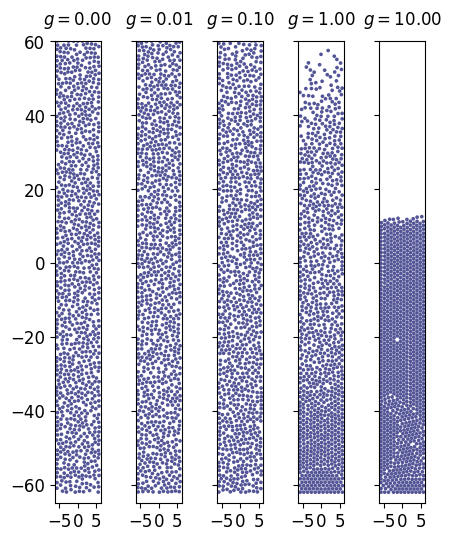

In [56]:
final_pos_g00 = np.loadtxt("results/5_final_positions_grav_g0.00_Lx12.5_delta0.100.txt")
x = final_pos_g00[:, 0]
y = final_pos_g00[:, 1]
final_pos_g01 = np.loadtxt("results/5_final_positions_grav_g0.01_Lx12.5_delta0.100.txt")
x1 = final_pos_g01[:, 0]    
y1 = final_pos_g01[:, 1]
final_pos_g10 = np.loadtxt("results/5_final_positions_grav_g0.10_Lx12.5_delta0.100.txt")
x2 = final_pos_g10[:, 0]
y2 = final_pos_g10[:, 1]
final_pos_g100 = np.loadtxt("results/5_final_positions_grav_g1.00_Lx12.5_delta0.100.txt")
x3 = final_pos_g100[:, 0]
y3 = final_pos_g100[:, 1]
final_pos_g1000 = np.loadtxt("results/5_final_positions_grav_g10.00_Lx12.5_delta0.100.txt")
x4 = final_pos_g1000[:, 0]
y4 = final_pos_g1000[:, 1]

from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

def add_disks(ax, x, y, radius=0.5, facecolor=None, edgecolor='black', lw=0.0):
    patches = [Circle((xi, yi), radius=radius) for xi, yi in zip(x, y)]
    pc = PatchCollection(patches, facecolor=facecolor, edgecolor=edgecolor, linewidths=lw)
    ax.add_collection(pc)
    return pc

fig, axs = plt.subplots(1, 5, figsize=(10, 6), sharey=True, gridspec_kw={'wspace': -0.82})

datasets = [(x, y, r"$g=0.00$"), (x1, y1, r"$g=0.01$"), (x2, y2, r"$g=0.10$"),
            (x3, y3, r"$g=1.00$"), (x4, y4, r"$g=10.00$")]

for ax, (xx, yy, title) in zip(axs, datasets):
    add_disks(ax, xx, yy, radius=0.5, facecolor=sunset2(0.2), edgecolor='black', lw=0.0)
    ax.set_title(title, fontsize=12, pad=12)
    ax.set_xlim(-7, 7)
    ax.set_ylim(-65, 60)
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_aspect('equal', adjustable='box')
    ax.set_box_aspect(10)

# fig.subplots_adjust(wspace=0.02, left=0.06, right=0.98, top=0.95, bottom=0.08)
plt.savefig('graphs/5_final_positions_grav_varios_g_Lx12.5_delta0.1.pdf', dpi=300, bbox_inches='tight')
plt.show()


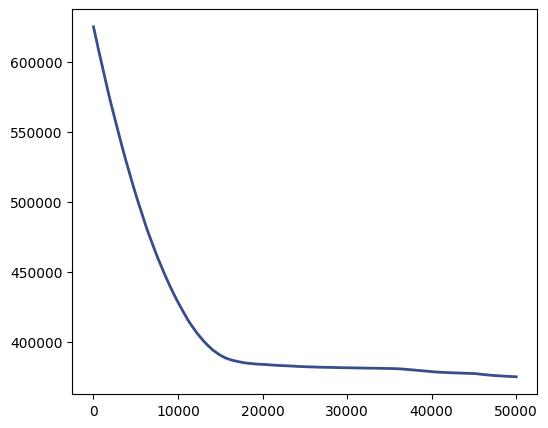

In [ ]:
energy_data = np.loadtxt("results/5_energy_grav_g10.00_Lx12.5_delta0.100.txt")
mc_steps = energy_data[:, 0]
energy = energy_data[:, 1]
plt.figure(figsize=(6,5))
plt.plot(mc_steps, energy, color=sunset2(0.1), lw=2)
# plt.xscale('log')
# plt.yscale('log')

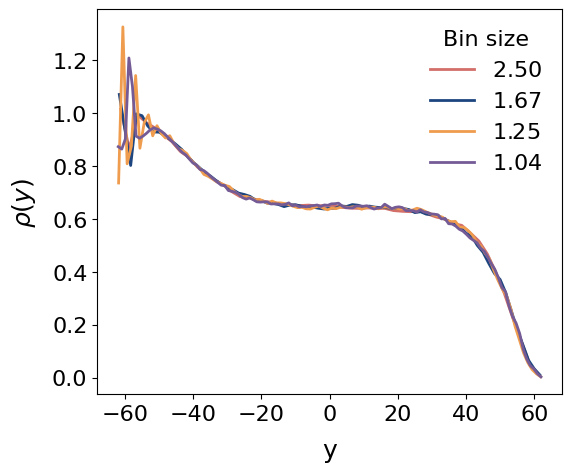

In [46]:
density_data_nbins50= np.loadtxt("results/bonus_density_profile_grav_g1.00_Lx12.5_delta0.100_nbin50_T1.0.txt")
y_50 = density_data_nbins50[:, 0]
rho_50 = density_data_nbins50[:, 1]

density_data_nbins75= np.loadtxt("results/bonus_density_profile_grav_g1.00_Lx12.5_delta0.100_nbin75_T1.0.txt")
y_75 = density_data_nbins75[:, 0]
rho_75 = density_data_nbins75[:, 1]

density_data_nbins100= np.loadtxt("results/bonus_density_profile_grav_g1.00_Lx12.5_delta0.100_nbin100_T1.0.txt")
y_100 = density_data_nbins100[:, 0]
rho_100 = density_data_nbins100[:, 1]

density_data_nbins120= np.loadtxt("results/bonus_density_profile_grav_g1.00_Lx12.5_delta0.100_nbin120_T1.0.txt")
y_120 = density_data_nbins120[:, 0]
rho_120 = density_data_nbins120[:, 1]

plt.figure(figsize=(6,5))

Lx = 12.5
Ly = 10*Lx

nbin = 50
b = Ly / nbin
plt.plot(y_50, rho_50, color=sunset2(0.6), lw=2, label = r'$%.2f$' % b)

nbin = 75
b = Ly / nbin
plt.plot(y_75, rho_75, color=sunset2(0.0), lw=2, label = r'$%.2f$' % b)

nbin = 100
b = Ly / nbin
plt.plot(y_100, rho_100, color=sunset2(0.9), lw=2, label = r'$%.2f$' % b)

nbin = 120
b = Ly / nbin
plt.plot(y_120, rho_120, color=sunset2(0.3), lw=2, label = r'$%.2f$' % b)


plt.xlabel('y', fontsize=18, labelpad=10 )
plt.ylabel(r'$\rho(y)$', fontsize=18, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, frameon=False, title = 'Bin size', title_fontsize=16)




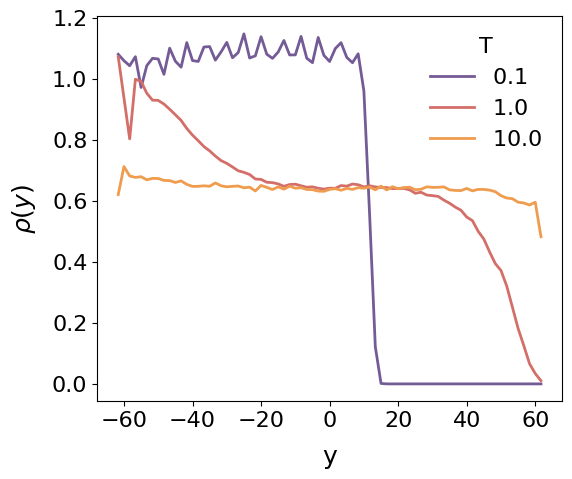

In [45]:

density_data_nbins75_T01= np.loadtxt("results/bonus_density_profile_grav_g1.00_Lx12.5_delta0.100_nbin75_T0.1.txt")
y_75_T01 = density_data_nbins75_T01[:, 0]
rho_75_T01 = density_data_nbins75_T01[:, 1]

density_data_nbins75_T1= np.loadtxt("results/bonus_density_profile_grav_g1.00_Lx12.5_delta0.100_nbin75_T1.0.txt")
y_75_T1 = density_data_nbins75_T1[:, 0]
rho_75_T1 = density_data_nbins75_T1[:, 1]

density_data_nbins75_T10= np.loadtxt("results/bonus_density_profile_grav_g1.00_Lx12.5_delta0.100_nbin75_T10.0.txt")
y_75_T10 = density_data_nbins75_T10[:, 0]
rho_75_T10 = density_data_nbins75_T10[:, 1]

plt.figure(figsize=(6,5))

Lx = 12.5
Ly = 10*Lx

nbin = 75
b = Ly / nbin
plt.plot(y_75_T01, rho_75_T01, color=sunset2(0.3), lw=2, label = r'$0.1$')
plt.plot(y_75_T1, rho_75_T1, color=sunset2(0.6), lw=2, label = r'$1.0$')
plt.plot(y_75_T10, rho_75_T10, color=sunset2(0.9), lw=2, label = r'$10.0$')

plt.xlabel('y', fontsize=18, labelpad=10 )
plt.ylabel(r'$\rho(y)$', fontsize=18, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, frameon=False, title = 'T', title_fontsize=16)




C:\Users\Admin\AppData\Local\Temp\ipykernel_18648\1194307429.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


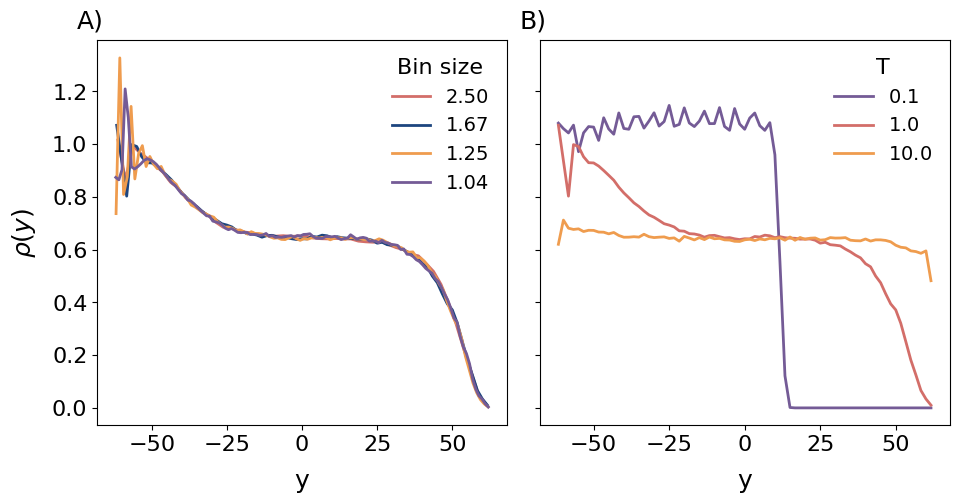

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# --- (ya tienes estos np.loadtxt arriba) ---

Lx = 12.5
Ly = 10*Lx

# Figura con 2 paneles
fig, axs = plt.subplots(1, 2, figsize=(11,5), sharey=True, gridspec_kw={'wspace': 0.08})
(axL, axR) = axs

# ---------------- A) Convergencia en b (nbins) ----------------
# izquierda
for nbin, (yy, rr), c in [
    (50,  (y_50,  rho_50),  sunset2(0.6)),
    (75,  (y_75,  rho_75),  sunset2(0.0)),
    (100, (y_100, rho_100), sunset2(0.9)),
    (120, (y_120, rho_120), sunset2(0.3)),
]:
    b = Ly/nbin
    axL.plot(yy, rr, lw=2, color=c, label=fr'{b:.2f}')

axL.set_xlabel('y', fontsize=18, labelpad=10)
axL.set_ylabel(r'$\rho(y)$', fontsize=18, labelpad=10)
axL.tick_params(labelsize=16)
leg = axL.legend(title='Bin size', frameon=False, fontsize=14, title_fontsize=16)
axL.text(-0.05, 1.03, 'A)', transform=axL.transAxes, fontsize=18)

# ---------------- B) Dependencia con T (nbins fijo) ----------------
# derecha (nbins = 75)
axR.plot(y_75_T01, rho_75_T01, lw=2, color=sunset2(0.3), label=r'$0.1$')
axR.plot(y_75_T1,  rho_75_T1,  lw=2, color=sunset2(0.6), label=r'$1.0$')
axR.plot(y_75_T10, rho_75_T10, lw=2, color=sunset2(0.9), label=r'$10.0$')

axR.set_xlabel('y', fontsize=18, labelpad=10)
# axR.set_ylabel(r'$\rho(y)$', fontsize=18, labelpad=10)
axR.tick_params(labelsize=16)
axR.legend(title='T', frameon=False, fontsize=14, title_fontsize=16)
axR.text(-0.05, 1.03, 'B)', transform=axR.transAxes, fontsize=18)

plt.tight_layout()
plt.savefig('graphs/5_density_profiles_grav_g1.0_Lx12.5_delta0.1.pdf', dpi=300, bbox_inches='tight')
plt.show()


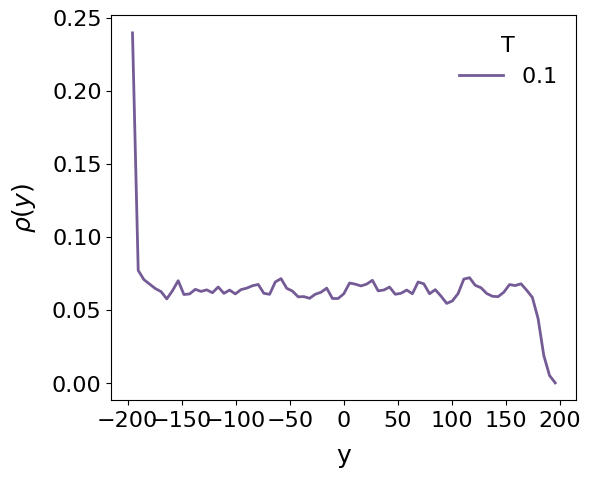

In [61]:

density_data_nbins75_T01= np.loadtxt("results/bonus_density_profile_grav_g1.00_Lx39.6_delta0.100_nbin75_T1.0.txt")
y_75_T01 = density_data_nbins75_T01[:, 0]
rho_75_T01 = density_data_nbins75_T01[:, 1]

plt.figure(figsize=(6,5))

Lx = 39.6
Ly = 10*Lx

nbin = 75
b = Ly / nbin
plt.plot(y_75_T01, rho_75_T01, color=sunset2(0.3), lw=2, label = r'$0.1$')

plt.xlabel('y', fontsize=18, labelpad=10 )
plt.ylabel(r'$\rho(y)$', fontsize=18, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, frameon=False, title = 'T', title_fontsize=16)


